In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import tensorflow as tf
import pickle

%matplotlib inline

/home/sw/Documents/dev/venvironment/mlenv/ml-dl/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
print('Running on tensorflow version: ', tf.__version__)

Running on tensorflow version:  1.9.0


In [3]:
'''From https://www.cs.toronto.edu/~kriz/cifar.html'''
def unpickle(file):
#     import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [4]:
# set directory of the pickled batch files
dir_prefix = './cifar-10-batches-py/'

In [5]:
def load_data(file_name):
    return unpickle(dir_prefix + file_name)

In [6]:
def process_batch(batch_np_array):
    num_instance = batch_np_array.shape[0]
    batch_reshape = batch_np_array.reshape(num_instance, 3, 1024)
    # transposes the 2nd and 3rd dim
    batch_reshape = batch_reshape.transpose((0, 2, 1))
    batch_reshape = batch_reshape.reshape(num_instance, 32, 32, 3)
    return batch_reshape

### Set some global variables

In [7]:
image_width = 32
image_height = 32
num_channels = 3
num_classes = 10

# info about dataset sizes
training_data_size = 50000
test_data_size = 10000

# model training parameters
batch_size = 64
## for training set
num_iteration_per_epoch = training_data_size // batch_size
if training_data_size % batch_size != 0:
    num_iteration_per_epoch += 1

### Examining/exploring data

In [8]:
label_name_dict = load_data('batches.meta')

In [9]:
label_name_list = label_name_dict[b'label_names']

In [10]:
label_name_list

[b'airplane',
 b'automobile',
 b'bird',
 b'cat',
 b'deer',
 b'dog',
 b'frog',
 b'horse',
 b'ship',
 b'truck']

In [11]:
batch_1_dict = load_data('data_batch_1')

In [12]:
len(batch_1_dict[b'labels'])

10000

In [13]:
batch_1_labels = batch_1_dict[b'labels']

In [14]:
batch_1_data = batch_1_dict[b'data']

In [15]:
batch_1_data.shape

(10000, 3072)

In [16]:
processed_batch_1 = process_batch(batch_1_data)

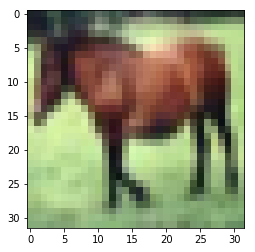

In [17]:
plt.imshow(processed_batch_1[7])

In [18]:
batch_2_dict = load_data('data_batch_2')

In [19]:
batch_2_data = batch_2_dict[b'data']

In [20]:
batch_2_labels = batch_2_dict[b'labels']

In [21]:
processed_batch_2 = process_batch(batch_2_data)

In [22]:
processed_batch_2.shape

(10000, 32, 32, 3)

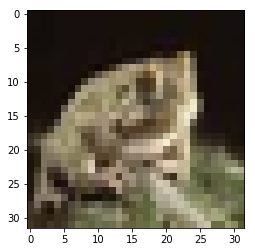

In [23]:
plt.imshow(processed_batch_2[1])

In [24]:
processed_batch_1.shape

(10000, 32, 32, 3)

In [25]:
processed_batch_2.shape

(10000, 32, 32, 3)

In [26]:
test_concat_data = np.concatenate((processed_batch_1, processed_batch_2), axis=0)

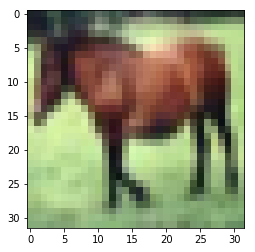

In [27]:
plt.imshow(test_concat_data[7])

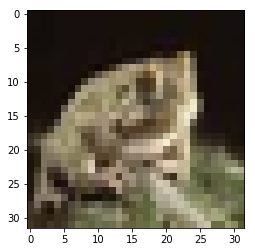

In [28]:
plt.imshow(test_concat_data[10001])

### Load and concat all 5 batches of training data

In [29]:
data_batch_list = []
label_batch_list = []
for i in range(1, 6):
    current_batch = load_data('data_batch_' + str(i))
    current_data = current_batch[b'data']
    current_label = current_batch[b'labels']
    current_data = process_batch(current_data)
    data_batch_list.append(current_data)
    label_batch_list = label_batch_list + current_label

In [30]:
len(data_batch_list)

5

In [31]:
data_batch_list[0].shape

(10000, 32, 32, 3)

In [32]:
training_data = np.concatenate(data_batch_list, axis=0)

In [33]:
training_data.shape

(50000, 32, 32, 3)

In [34]:
len(label_batch_list)

50000

In [35]:
training_label = np.zeros((training_data.shape[0], num_classes))

In [36]:
training_label.shape

(50000, 10)

In [37]:
for i in range(50000):
    true_label = label_batch_list[i]
    training_label[i][true_label] += 1

In [38]:
# one hot vector for labels
training_label

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]])

In [39]:
training_label.shape

(50000, 10)

#### Prepare test data

In [40]:
test_data_dict = load_data('test_batch')

In [41]:
test_label_list = test_data_dict[b'labels']

In [42]:
test_data = test_data_dict[b'data']

In [43]:
test_data = test_data.reshape([-1, 32, 32, 3])

In [44]:
test_data.shape

(10000, 32, 32, 3)

In [45]:
test_label = np.zeros([len(test_label_list), num_classes])

for i in range(len(test_label_list)):
    current_label = test_label_list[i]
    test_label[i][current_label] += 1

### Setting up tf datasets and iterators for training and testing

In [46]:
# we want to convert the datatype of the pixel values from uint8 to float16 or 32 so that 
# tensorflow can accept input
test_data = test_data.astype(np.float32, copy=False)
training_data = training_data.astype(np.float32, copy=False)

In [47]:
train_dataset = tf.data.Dataset.from_tensor_slices((training_data, training_label)).batch(batch_size).repeat()

In [48]:
test_dataset = tf.data.Dataset.from_tensor_slices((test_data, test_label)).batch(test_data_size).repeat()

In [49]:
iterator_input = tf.data.Iterator.from_structure(train_dataset.output_types, train_dataset.output_shapes)

In [50]:
init_train_op = iterator_input.make_initializer(train_dataset)
init_test_op = iterator_input.make_initializer(test_dataset)

In [51]:
train_dataset.output_types

(tf.float64, tf.float64)

### Training

In [52]:
#tf.reset_default_graph()

In [53]:
data_instance, label_instance = iterator_input.get_next()

In [54]:
# build model

# x = tf.placeholder(tf.float32, shape=[None, image_height, image_width, num_channels], name='x')

# y = tf.placeholder(tf.float32, shape=[None, num_classes], name='y_true')

conv1 = tf.layers.conv2d(inputs=data_instance, filters=32, kernel_size=[3, 3], activation='relu', padding='same', strides=[1, 1], name='conv_layer_1')

conv1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2, name='max_pool_1')

# conv1 = tf.layers.batch_normalization(inputs=conv1, name='batch_norm_1')

conv2 = tf.layers.conv2d(inputs=conv1, filters=64, kernel_size=[5, 5], activation='relu', padding='same', strides=1, name='conv_layer_2')

conv2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2, name='max_pool_2')

flat1 = tf.layers.flatten(inputs=conv2)

dense1 = tf.layers.dense(inputs=flat1, units=1024, activation='relu', name='dense_layer_1')

dropout1 = tf.layers.dropout(inputs=dense1, rate=0.4, name='dropout_layer_1')

dense2 = tf.layers.dense(inputs=dropout1, units=10, activation='softmax', name='softmax_output_layer')

In [55]:
y_pred = dense2
y_pred_cls = tf.argmax(y_pred, axis=1)

In [56]:
# stop backpropagation to labels
label_instance_stopped = tf.stop_gradient(label_instance)

In [57]:
cost_function = tf.nn.softmax_cross_entropy_with_logits_v2(labels=label_instance_stopped, logits=dense2)

In [58]:
cost = tf.reduce_mean(cost_function)

In [59]:
optimizer = tf.train.AdamOptimizer()

In [60]:
train = optimizer.minimize(cost)

In [61]:
correct_prediction = tf.equal(y_pred_cls, tf.argmax(label_instance, axis=1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [62]:
session = tf.Session()

In [63]:
session.run(tf.global_variables_initializer())

In [66]:
## testing

In [80]:
session.run(init_test_op)

In [82]:
session.run(cost)

2.3611503

In [78]:
session.run(cost)

2.3611503

In [70]:
print(accuracy)

Tensor("Mean_1:0", shape=(), dtype=float32)


In [107]:
session.run(init_train_op)

In [79]:
for _ in range(100):
    session.run(train)

In [85]:
print(session.run(data_instance).shape)

(64, 32, 32, 3)


In [93]:
session.run(conv2).shape

(64, 4, 4, 64)

In [95]:
session.run(flat1).shape

(64, 1024)

In [115]:
temp1 = session.run(dense2)

In [123]:
temp2 = session.run(dense2)

In [125]:
temp3 = session.run(dense2)

In [126]:
np.array_equal(temp1, temp3)

True

In [118]:
session.run(train)

In [130]:
temp_label = session.run(label_instance)

In [128]:
temp1

array([[0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 

In [80]:
session.run(dropout1)

array([[  0.      ,   0.      , 100.94106 , ...,   0.      ,   0.      ,
          0.      ],
       [  0.      ,   0.      , 138.75151 , ...,   0.      ,   0.      ,
          0.      ],
       [  0.      ,   0.      , 129.44606 , ...,   0.      ,   0.      ,
          0.      ],
       ...,
       [  0.      ,   0.      , 105.379105, ...,   0.      ,   0.      ,
          0.      ],
       [  0.      ,   0.      , 121.354614, ...,   0.      ,   0.      ,
          0.      ],
       [  0.      ,   0.      , 121.33337 , ...,   0.      ,   0.      ,
          0.      ]], dtype=float32)

In [79]:
session.run(dropout1)

array([[  0.      ,   0.      , 100.94106 , ...,   0.      ,   0.      ,
          0.      ],
       [  0.      ,   0.      , 138.75151 , ...,   0.      ,   0.      ,
          0.      ],
       [  0.      ,   0.      , 129.44606 , ...,   0.      ,   0.      ,
          0.      ],
       ...,
       [  0.      ,   0.      , 105.379105, ...,   0.      ,   0.      ,
          0.      ],
       [  0.      ,   0.      , 121.354614, ...,   0.      ,   0.      ,
          0.      ],
       [  0.      ,   0.      , 121.33337 , ...,   0.      ,   0.      ,
          0.      ]], dtype=float32)

In [75]:
temp = session.run(tf.trainable_variables()[0])

In [77]:
temp2 = session.run(tf.trainable_variables()[0])

In [78]:
np.array_equal(temp, temp2)

True

In [64]:
# function to wrap around the training process
def train_epoches(num_epoch, num_iteration_per_epoch, epoch_print_freq):
    for i in range(1, num_epoch + 1):
        # init training data
        session.run(init_train_op)
        # train
        for j in range(num_iteration_per_epoch):
            session.run(train)
        # run test and print information if needed
        if i % epoch_print_freq == 0:
            session.run(init_test_op)
            print('Epoch: ', i)
            print('Loss: ', session.run(cost))
            print('Accuracy: ', session.run(accuracy))

In [65]:
# need to debug why the loss/cost is nan --- before it was because I was using tf.float16 and range exceeded.

In [67]:
# need to debug why the loss and accuracy is not changing/improving

In [65]:
train_epoches(num_epoch=10, num_iteration_per_epoch=num_iteration_per_epoch, epoch_print_freq=1)

Epoch:  1
Loss:  2.361150171734475
Accuracy:  0.1
Epoch:  2
Loss:  2.361150171734475
Accuracy:  0.1
Epoch:  3
Loss:  2.361150171734475
Accuracy:  0.1


KeyboardInterrupt: 

In [66]:
50000 // 64.0

781.0

In [78]:
# set the number of times to iterate the training data
num_epoch = 1000

In [81]:
for i in range(num_epoch):
#     print('epoch: ', i)
    tf_input_data = tf_input_data.shuffle(buffer_size=50)
    for j in range(training_data_size // batch_size + 1):
#         if j % 100 == 0:
#             print('batch : ', j)
#             print('accuracy', session.run(accuracy))
        session.run(train)
    
    if i % 10 == 0:
        print('epoch: ', i)
        print('batch : ', j)
        print('accuracy', session.run(accuracy))

epoch:  0
batch :  781
accuracy 0.109375
epoch:  10
batch :  781
accuracy 0.125
epoch:  20
batch :  781
accuracy 0.078125
epoch:  30
batch :  781
accuracy 0.140625
epoch:  40
batch :  781
accuracy 0.078125
epoch:  50
batch :  781
accuracy 0.046875
epoch:  60
batch :  781
accuracy 0.078125
epoch:  70
batch :  781
accuracy 0.171875
epoch:  80
batch :  781
accuracy 0.171875
epoch:  90
batch :  781
accuracy 0.09375
epoch:  100
batch :  781
accuracy 0.125
epoch:  110
batch :  781
accuracy 0.078125
epoch:  120
batch :  781
accuracy 0.078125
epoch:  130
batch :  781
accuracy 0.078125
epoch:  140
batch :  781
accuracy 0.078125
epoch:  150
batch :  781
accuracy 0.15625


KeyboardInterrupt: 